# **Stack Overflow Developer Analysis**
---

In [1]:
__author__ = "Tuan Nguyen"
__email__ = "nguyentuan250102@gmail.com"
__github__ = "https://github.com/nguyentuan251"

## **Motivation**

As a technology student or a coder, you might wonder:

*    Will you earn more salary as you gain more industry experience? If so how much more?
*   Do other factors such as the formal degree, position type, and the size of the company affect your salaries?

In this project, I will try to answer these questions using visualization and Bayesian inference in Python.


## **Collecting The Data**

To get a realistic result, we will use the data collected from individual responses on the 2021 Developer Survey fielded by Stack Overflow.

Start by downloading the data to your current directory then run:

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [155]:
df = pd.read_csv("/content/gdrive/MyDrive/stack-overflow-developer-survey-2021/survey_results_public.csv")

In [156]:
df.head() 

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN


In [157]:
df["EdLevel"].unique()

array(['Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Other doctoral degree (Ph.D., Ed.D., etc.)',
       'Some college/university study without earning a degree',
       'Something else', 'Professional degree (JD, MD, etc.)',
       'Primary/elementary school', 'Associate degree (A.A., A.S., etc.)',
       nan], dtype=object)

In [158]:
df["EdLevel"] = df["EdLevel"].map(
    {
        "Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "Bachelor’s degree",
        "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "Master’s degree",
        "Some college/university study without earning a degree": "Some college/university study without degree",
        "Associate degree": "Associate degree",
        "Other doctoral degree (Ph.D., Ed.D., etc.)": "Doctoral degree",
        "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "Secondary school",
        "Professional degree (JD, MD, etc.)": "Professional degree",
        "Primary/elementary school": "Primary/elementary school",
        "Something else": "Something else",
    }
)

In [159]:
companySize_to_interval = {
    "Just me - I am a freelancer, sole proprietor, etc.": pd.Interval(0, 10),
    "10 to 19 employees": pd.Interval(10, 19),
    "20 to 99 employees": pd.Interval(20, 99),
    "100 to 499 employees": pd.Interval(100, 499),
    "500 to 999 employees": pd.Interval(500, 999),
    "1,000 to 4,999 employees": pd.Interval(1000, 4999),
    "5,000 to 9,999 employees": pd.Interval(5000, 9999),
    "10,000 or more employees": pd.Interval(10000, float("inf")),
}

df['OrgSize'] = df['OrgSize'].map(companySize_to_interval)

> Since the salary is various for different countries and for different employment types, we only select the developers that are in the United States and have full-time employment as United States is considered as the highest technological country.

In [160]:
sample = df.query(
    "Country == 'United States of America' & Employment == 'Employed full-time'"
)

> We will also filter out extreme values of salary that are above $500,000.

In [161]:
normal_salary = sample[sample["ConvertedCompYearly"] < 500_000].copy()

Besides, all respondents who did not fill their salary and years of coding should be removed.

In [162]:
normal_salary.dropna(subset=["ConvertedCompYearly", "YearsCode"], inplace=True)

In [163]:
bins = [0, 25_000, 50_000, 75_000, 100_000, 125_000, 150_000, 300_000, 500_000]

normal_salary["Salary_Range"] = pd.cut(
    normal_salary["ConvertedCompYearly"], bins=bins
)

salary_groupby = normal_salary.groupby("Salary_Range").agg({"ResponseId": "count"})
salary_groupby

,ResponseId
Salary_Range,
"(0, 25000]",52
"(25000, 50000]",280
"(50000, 75000]",945
"(75000, 100000]",1647
"(100000, 125000]",1686
"(125000, 150000]",1581
"(150000, 300000]",2336
"(300000, 500000]",216


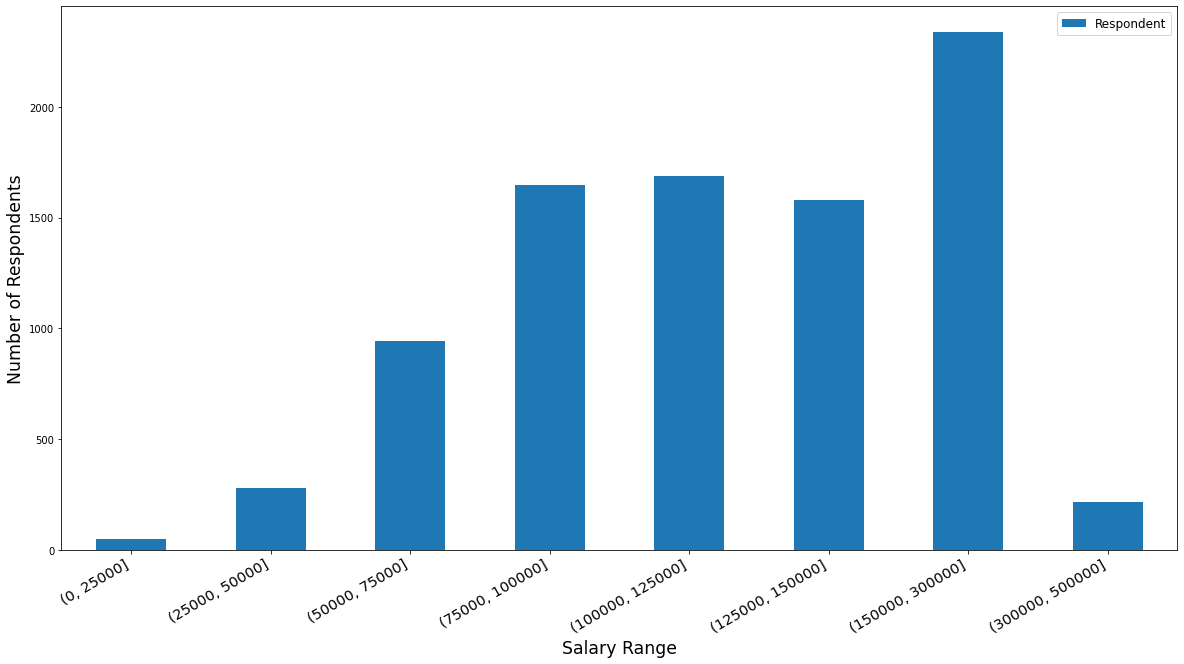

In [164]:
salary_groupby.plot(kind="bar")
plt.xticks(rotation=30, ha="right", fontsize="x-large")
plt.legend(fontsize="large", loc="best", labels=["Respondent"])
plt.xlabel("Salary Range", fontsize="xx-large")
plt.ylabel("Number of Respondents", fontsize="xx-large")
plt.rcParams['figure.figsize'] = [10,6]
plt.show()


In [165]:
normal_salary["YearsCode"].replace({'Less than 1 year': 0, 'More than 50 years': 50}, inplace=True)

In [166]:
normal_salary

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly,Salary_Range
36,37,I am a developer by profession,Employed full-time,United States of America,District of Columbia,NaN,Bachelor’s degree,11 - 17 years,"Other online resources (ex: videos, blogs, etc...",8,...,Man,No,Straight / Heterosexual,White or of European descent,None of the above,Prefer not to say,Too short,Easy,103000.0,"(100000, 125000]"
37,38,I am a developer by profession,Employed full-time,United States of America,Massachusetts,NaN,Some college/university study without degree,18 - 24 years,"Other online resources (ex: videos, blogs, etc)",20,...,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,300000.0,"(150000, 300000]"
62,63,"I am not primarily a developer, but I write co...",Employed full-time,United States of America,New York,NaN,Bachelor’s degree,11 - 17 years,Online Forum,13,...,Man,No,Straight / Heterosexual,NaN,NaN,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,130000.0,"(125000, 150000]"
75,76,I am a developer by profession,Employed full-time,United States of America,Minnesota,NaN,Bachelor’s degree,11 - 17 years,"Other online resources (ex: videos, blogs, etc...",25,...,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,105000.0,"(100000, 125000]"
87,88,I am a developer by profession,Employed full-time,United States of America,Maryland,NaN,Doctoral degree,11 - 17 years,"Other online resources (ex: videos, blogs, etc...",18,...,Man,No,Straight / Heterosexual,South Asian,None of the above,None of the above,Appropriate in length,Easy,100000.0,"(75000, 100000]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83404,83405,I am a developer by profession,Employed full-time,United States of America,California,NaN,Bachelor’s degree,18 - 24 years,"Other online resources (ex: videos, blogs, etc...",4,...,Man,No,Straight / Heterosexual,White or of European descent;Hispanic or Latin...,None of the above,I have a mood or emotional disorder (e.g. depr...,Appropriate in length,Easy,85000.0,"(75000, 100000]"
83416,83417,I am a developer by profession,Employed full-time,United States of America,New Mexico,NaN,Bachelor’s degree,11 - 17 years,School;Friend or family member;Books / Physica...,34,...,Man,No,Straight / Heterosexual,Hispanic or Latino/a/x,None of the above,None of the above,Appropriate in length,Easy,15500.0,"(0, 25000]"
83430,83431,I am a developer by profession,Employed full-time,United States of America,Illinois,NaN,Master’s degree,11 - 17 years,"Other online resources (ex: videos, blogs, etc...",23,...,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,125000.0,"(100000, 125000]"
83434,83435,I am a developer by profession,Employed full-time,United States of America,Texas,NaN,Bachelor’s degree,11 - 17 years,"Other online resources (ex: videos, blogs, etc...",6,...,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,160500.0,"(150000, 300000]"


In [167]:
# normal_salary["YearsCode"].astype('int')
normal_salary["YearsCode"] = normal_salary["YearsCode"].astype(int)

In [168]:
# Group by years of code range
bins = [0, 3, 5, 7, 9, 11, 15, 20, 30, 50]

normal_salary["YearsCoding_Range"] = pd.cut(
    normal_salary["YearsCode"], bins=bins
)

yearsCoding_groupby = normal_salary.groupby("YearsCoding_Range").agg({"ResponseId": "count"})
yearsCoding_groupby

,ResponseId
YearsCoding_Range,
"(0, 3]",251
"(3, 5]",610
"(5, 7]",912
"(7, 9]",765
"(9, 11]",998
"(11, 15]",1331
"(15, 20]",1245
"(20, 30]",1537
"(30, 50]",1088


In [169]:
normal_salary.dropna(subset=["YearsCoding_Range"], inplace=True)

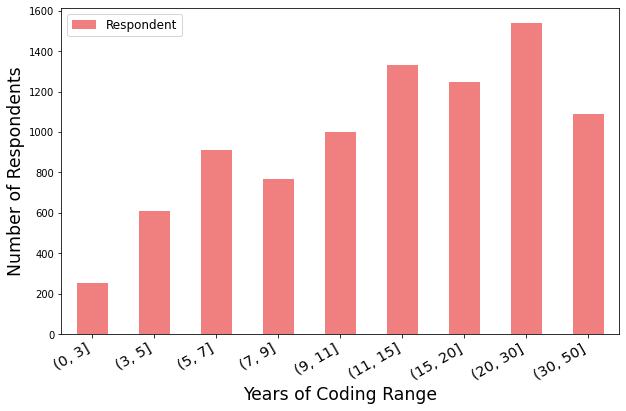

In [170]:
yearsCoding_groupby.plot(kind="bar", color="lightcoral")
plt.xticks(rotation=30, ha="right", fontsize="x-large")
plt.legend(fontsize="large", loc="best", labels=["Respondent"])
plt.xlabel("Years of Coding Range", fontsize="xx-large")
plt.ylabel("Number of Respondents", fontsize="xx-large")
plt.rcParams['figure.figsize'] = [12,7]
plt.show()


In [171]:
# Sort by years of coding
years_sorted = normal_salary.sort_values(by="YearsCode")

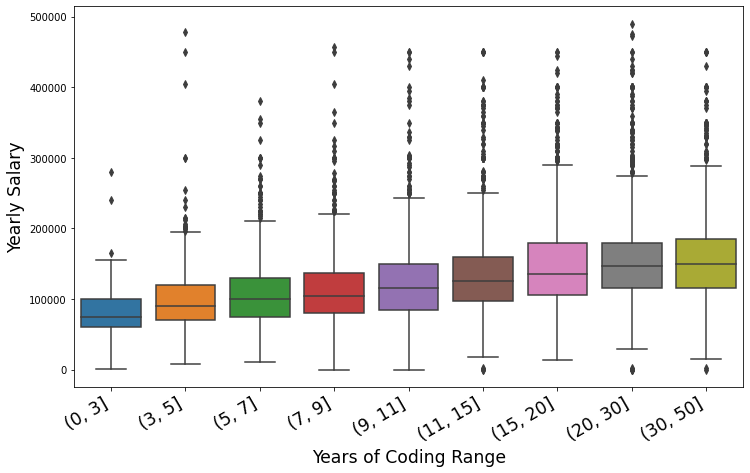

In [172]:
sns.boxplot(data=years_sorted, x="YearsCoding_Range", y="ConvertedCompYearly")
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("Years of Coding Range", fontsize="xx-large")
plt.ylabel("Yearly Salary", fontsize="xx-large")
plt.rcParams['figure.figsize'] = [20,12]
plt.show()

Great! It seems like the mean salary increases as the years of coding increase!

Note that the data above is just a sample of developers. How are we sure that there is a significant difference in mean salary between 3–5 years and 0–3 years of experience or 7-9 years and 0–3 years of experience? 

Now I will check that using a two-sample Bayesian t-test.

## Bayesian t-test on 2 Different Years of Experience

Before comparing multiple years of experience at once, let’s start with comparing the mean salaries of two different years of experience: 0–3 years of experience vs 3–5 years of experience.

> ### **We denote**:

#### µ1 : Mean salary of developers with 0-3 years of experience  
#### µ2 : Mean salary of developers with 3-5 years of experience  
#### β: Difference in mean salary between 0-3 and 3-5 years of experience


From the equation above, we will check if there is no difference in mean salaries between the 2 groups, then 𝛽 = 0.  

We will use Bambi to draw 4000 samples 𝛽 and find the distribution of 𝛽. We will assume that the salary distributions of 0–3 years and 3–5 years are normal.

In [173]:
# !pip install arviz
# !pip install bambi

In [174]:
import arviz as az
import bambi as bmb

sample1 = years_sorted[
    (years_sorted["YearsCoding_Range"] == pd.Interval(0, 3, closed='right'))
    | (years_sorted["YearsCoding_Range"] == pd.Interval(3, 5, closed='right'))
]

# Convert to string
sample1["YearsCoding_Range"] = sample1["YearsCoding_Range"].astype(str)

# Build model
model1 = bmb.Model("ConvertedCompYearly ~ YearsCoding_Range", sample1)
result1 = model1.fit(random_seed=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ConvertedCompYearly_sigma, YearsCoding_Range, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [175]:
az.summary(result1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,80382.462,2853.338,75381.425,85914.832,59.773,42.272,2275.0,1332.0,1.0
"YearsCoding_Range[(3, 5]]",19066.178,3308.844,12826.281,25063.450,70.583,50.729,2202.0,1421.0,1.0
ConvertedCompYearly_sigma,44119.270,1088.602,42081.703,46149.048,20.473,14.504,2815.0,1657.0,1.0


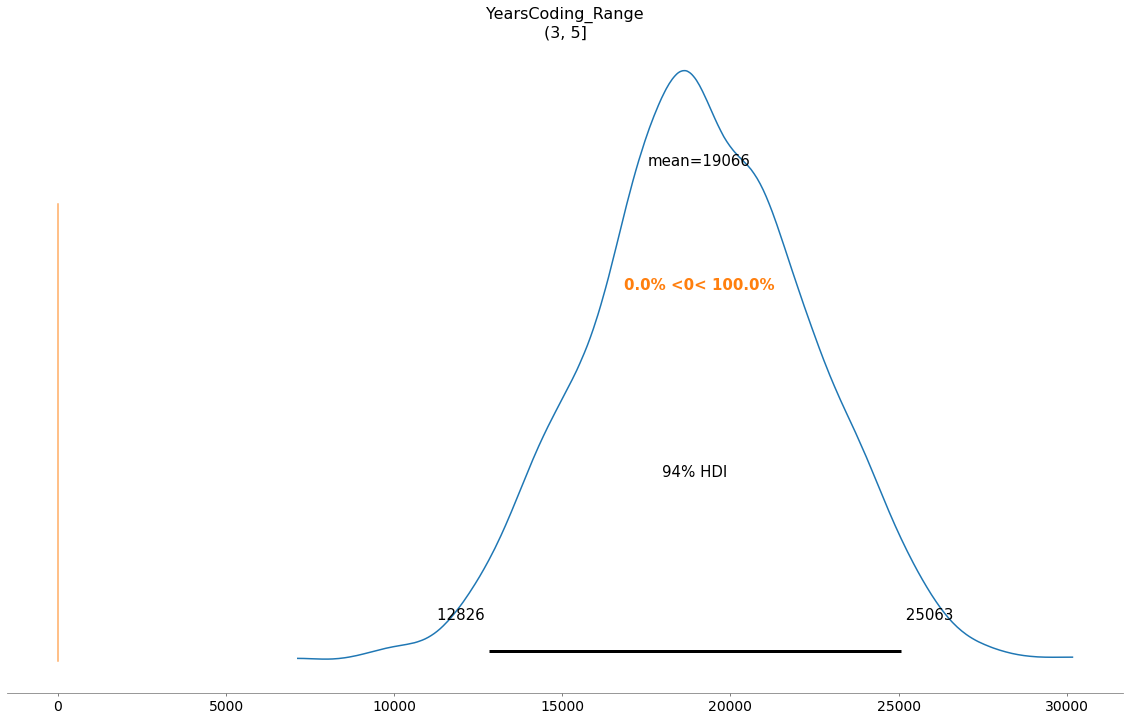

In [176]:
az.plot_posterior(result1.posterior["YearsCoding_Range"], ref_val=0)

### From the distribution above, we can say that:  
 

*   The mean difference in salary of the 2 groups is 19,066. 
*   94% of the difference in salary between the 2 groups lie between 12826 and 25063.


Since all values of 𝛽 are much higher than 0, we can certainly say  that there is a significant difference between the mean salary of developers with 0–3 years of experience and those with 3–5 years of experience.




### Let’s double-check if all values of 𝛽 are greater than 0:

In [177]:
(result1.posterior["YearsCoding_Range"] > 1).values.mean()

1.0

Amazing! They all are.

## Bayesian t-test on Multiple Years of Experience

#### Now, let’s compare other years of experience with 0–2 years of experience.

In [178]:
years_sorted["YearsCoding_Range"] = years_sorted["YearsCoding_Range"].astype(str)

all_model = bmb.Model("ConvertedCompYearly ~ YearsCoding_Range", years_sorted)
all_results = all_model.fit(random_seed=0)

yearsCoding_summary = (
    az.summary(all_results)
    .drop(["ConvertedCompYearly_sigma", "Intercept"])
    .sort_values(by="mean")
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ConvertedCompYearly_sigma, YearsCoding_Range, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 45 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [179]:
yearsCoding_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"YearsCoding_Range[(3, 5]]",19007.906,4466.040,11187.626,27899.867,207.784,147.018,461.0,703.0,1.01
"YearsCoding_Range[(5, 7]]",29115.297,4328.986,20235.859,36202.987,193.669,137.025,501.0,563.0,1.01
"YearsCoding_Range[(7, 9]]",34474.375,4420.927,26257.554,43068.956,203.829,144.218,479.0,606.0,1.01
"YearsCoding_Range[(9, 11]]",44554.596,4254.849,36642.954,52481.289,200.377,141.780,453.0,645.0,1.01
"YearsCoding_Range[(11, 15]]",57080.525,4128.362,49125.199,64606.400,190.126,134.523,482.0,685.0,1.01
"YearsCoding_Range[(15, 20]]",69390.552,4192.346,60874.018,76795.978,188.947,133.685,494.0,658.0,1.01
"YearsCoding_Range[(20, 30]]",77059.748,4138.486,69346.913,84827.939,185.740,131.415,498.0,596.0,1.01
"YearsCoding_Range[(30, 50]]",78008.517,4225.587,70615.262,86496.697,187.060,132.347,513.0,614.0,1.01


### From the table above, we can conclude that:
   

*   The mean salary difference increases as years of coding increase.
*   As the years of coding experience get larger, the increase in mean salary for every extra year of coding gets smaller.



## **Other Factors that might Affect Salary**

We have known that years of coding experience do affect salary.  
But how about other factors such as formal education, position type, and the size of the company?

### **Salary by Formal Education**
Does the formal degree affect how much you earn? 
Let's find out using a box plot whose boxes are sorted based on the increase in the level of education.

In [180]:
ordered_degrees = [
    "Primary/elementary school",
    "Secondary school",
    "Some college/university study without degree",
    "Bachelor’s degree",
    "Master’s degree",
    "Professional degree",
    "Doctoral degree",
    "Something else"
]

salary_edu = sample[sample["ConvertedCompYearly"] < 500_000].copy()

salary_edu["EdLevel"] = salary_edu["EdLevel"].astype("category")
salary_edu["EdLevel"].cat.set_categories(
    ordered_degrees, ordered=True, inplace=True
)

sort_by_education = salary_edu.dropna(subset=["ConvertedCompYearly", "EdLevel"]).sort_values(by="EdLevel")

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


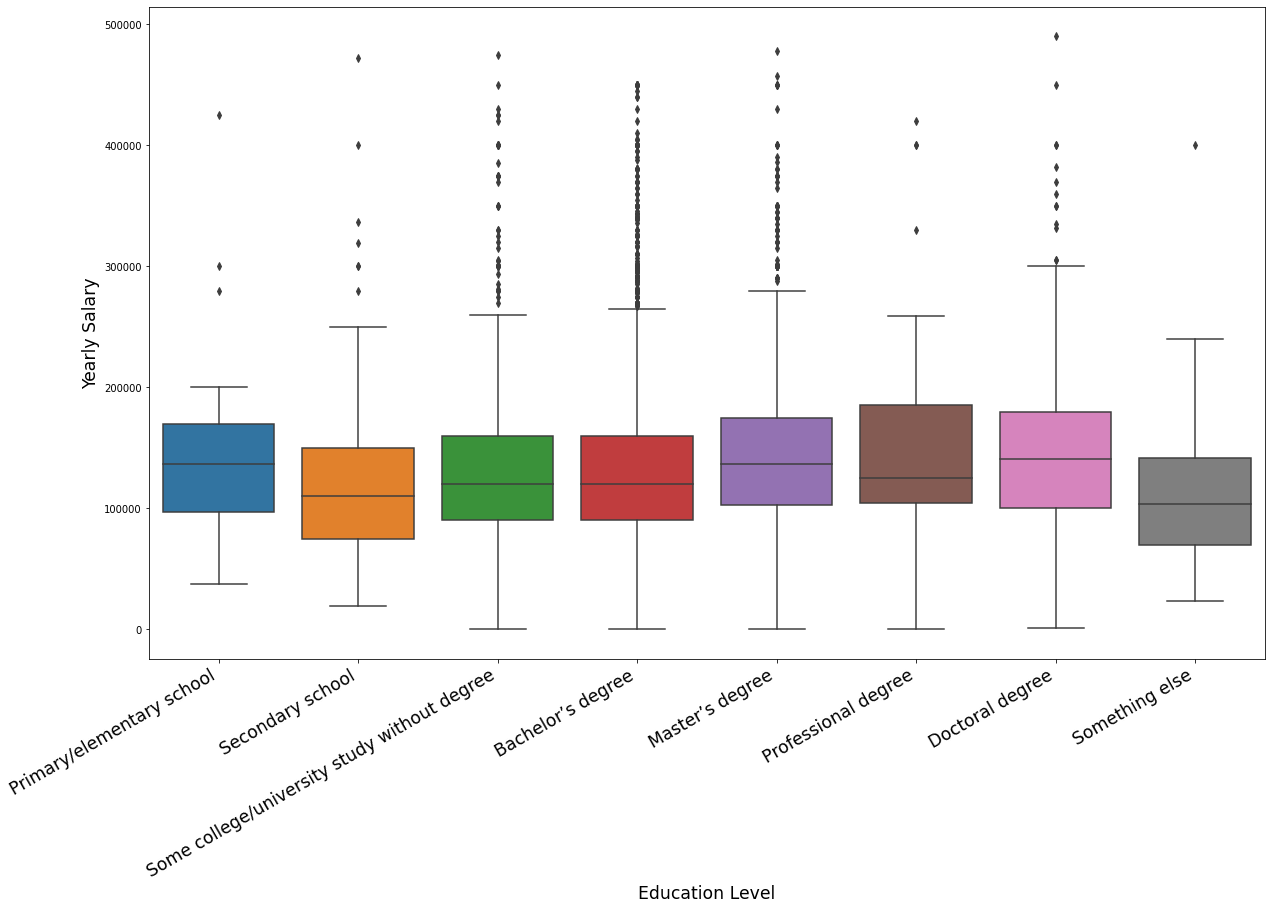

In [182]:
sns.boxplot(data=sort_by_education = salary_edu.dropna(subset=["ConvertedCompYearly", "EdLevel"]).sort_values(by="EdLevel")
, x="EdLevel", y="ConvertedCompYearly")
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("Education Level", fontsize="xx-large")
plt.ylabel("Yearly Salary", fontsize="xx-large")
plt.rcParams['figure.figsize'] = [20,10]
plt.show()

# EdLevel OrgSize DevType

In the plot above, those with no formal degree seem to earn as much as those with a Bachelor’s degree on average and it is the same for Master's degree and Doctoral degree. Thus, we can say that there is little correlation between the level of the formal degree and salary.

However if you had completed a Bachelor's degree, you should consider taking a Master's degree as well!

### **Salary by Company Size**


In [183]:
salary_size = sample[sample["ConvertedCompYearly"] < 500_000].copy()
size_sorted = salary_size.sort_values(by="OrgSize")

In [184]:
size_sorted

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
5699,5700,I am a developer by profession,Employed full-time,United States of America,Texas,NaN,Bachelor’s degree,11 - 17 years,Coding Bootcamp;Other online resources (ex: vi...,11,...,25-34 years old,Man,No,Prefer not to say,East Asian,None of the above,None of the above,Too long,Neither easy nor difficult,140000.0
6113,6114,I am a developer by profession,Employed full-time,United States of America,Florida,NaN,Doctoral degree,25 - 34 years,Online Forum,3,...,35-44 years old,Man,No,Straight / Heterosexual,South Asian,None of the above,None of the above,Appropriate in length,Easy,47500.0
8671,8672,"I am not primarily a developer, but I write co...",Employed full-time,United States of America,New York,NaN,Master’s degree,11 - 17 years,School;Books / Physical media,More than 50 years,...,65 years or older,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,100000.0
17567,17568,I am a developer by profession,Employed full-time,United States of America,Florida,NaN,Bachelor’s degree,Older than 64 years,"Other online resources (ex: videos, blogs, etc...",More than 50 years,...,65 years or older,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,50000.0
19517,19518,I am a developer by profession,Employed full-time,United States of America,Illinois,NaN,Bachelor’s degree,11 - 17 years,"Other online resources (ex: videos, blogs, etc...",40,...,45-54 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,None of the above,Appropriate in length,Neither easy nor difficult,95000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83204,83205,I am a developer by profession,Employed full-time,United States of America,District of Columbia,NaN,Master’s degree,11 - 17 years,"Other online resources (ex: videos, blogs, etc...",11,...,25-34 years old,Man,No,Straight / Heterosexual;Bisexual,White or of European descent,NaN,I have a concentration and/or memory disorder ...,Appropriate in length,Neither easy nor difficult,114000.0
83242,83243,I am a developer by profession,Employed full-time,United States of America,Iowa,NaN,Bachelor’s degree,11 - 17 years,School;Books / Physical media,7,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,Prefer not to say,Appropriate in length,Easy,92000.0
83252,83253,I am a developer by profession,Employed full-time,United States of America,Washington,NaN,Bachelor’s degree,11 - 17 years,School;Colleague,4,...,25-34 years old,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,108000.0
83312,83313,I am a developer by profession,Employed full-time,United States of America,Texas,NaN,Some college/university study without degree,11 - 17 years,Books / Physical media,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200000.0


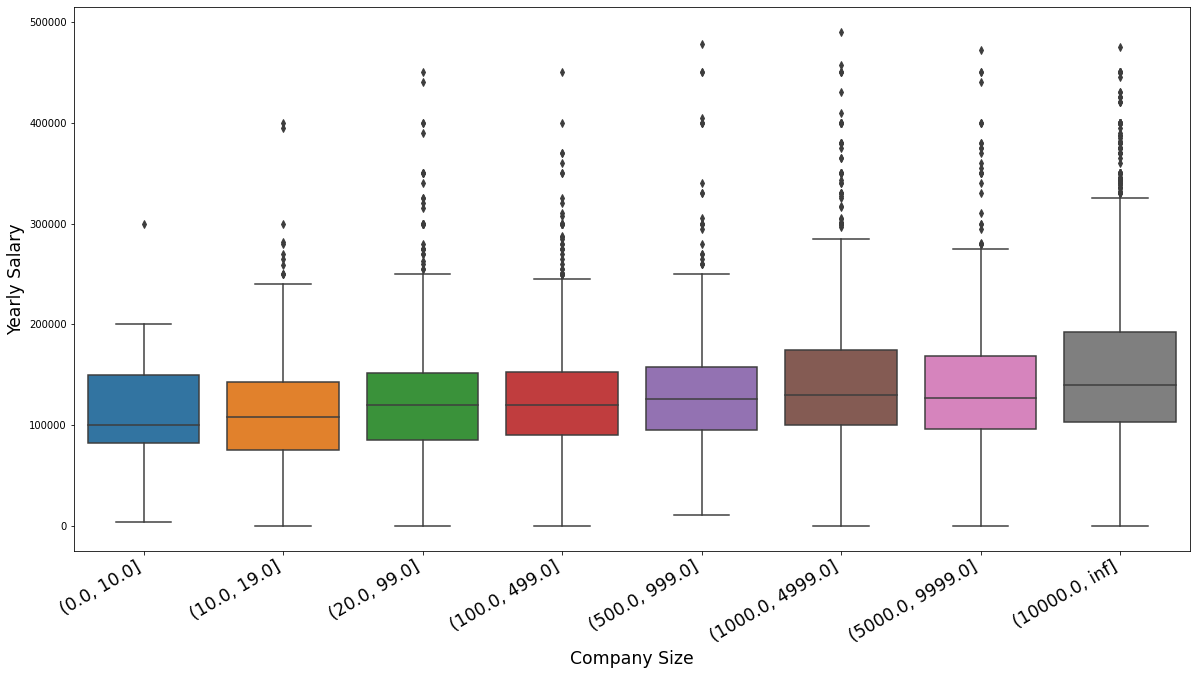

In [185]:
sns.boxplot(
    data=size_sorted,
    x="OrgSize",
    y="ConvertedCompYearly",
)
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("Company Size", fontsize="xx-large")
plt.ylabel("Yearly Salary", fontsize="xx-large")
plt.show()

> From the box plot above, we can see that the median salaries of bigger companies seem to increase slightly compared to the median salaries of smaller companies.

### **Salary by Developer Type**
Do certain types of developers earn more than others? .

In [186]:
def str_to_list(text: str):
    if isinstance(text, str):
        return text.split(";")
    return text

In [187]:
salary_devtype = sample[sample["ConvertedCompYearly"] < 500_000].copy()
salary_devtype["DevType"]

36             Developer, embedded applications or devices
37                                     Developer, back-end
62       Developer, front-end;Developer, desktop or ent...
75       Developer, front-end;Developer, full-stack;Dev...
87       Engineer, data;Data scientist or machine learn...
                               ...                        
83404                                Developer, QA or test
83416                              Other (please specify):
83430    Developer, front-end;Developer, full-stack;Dev...
83434                                  Developer, back-end
83436    Data scientist or machine learning specialist;...
Name: DevType, Length: 8783, dtype: object

In [188]:
salary_devtype["DevType"] = salary_devtype["DevType"].apply(str_to_list)

In [189]:
devtype = salary_devtype.explode(column="DevType").dropna(
    subset=["ConvertedCompYearly", "DevType"]
)

In [190]:
sorted_dev = (
    devtype[["ConvertedCompYearly", "DevType"]]
    .groupby("DevType")
    .median()
    .sort_values(by="ConvertedCompYearly", ascending=False)
    .index
)

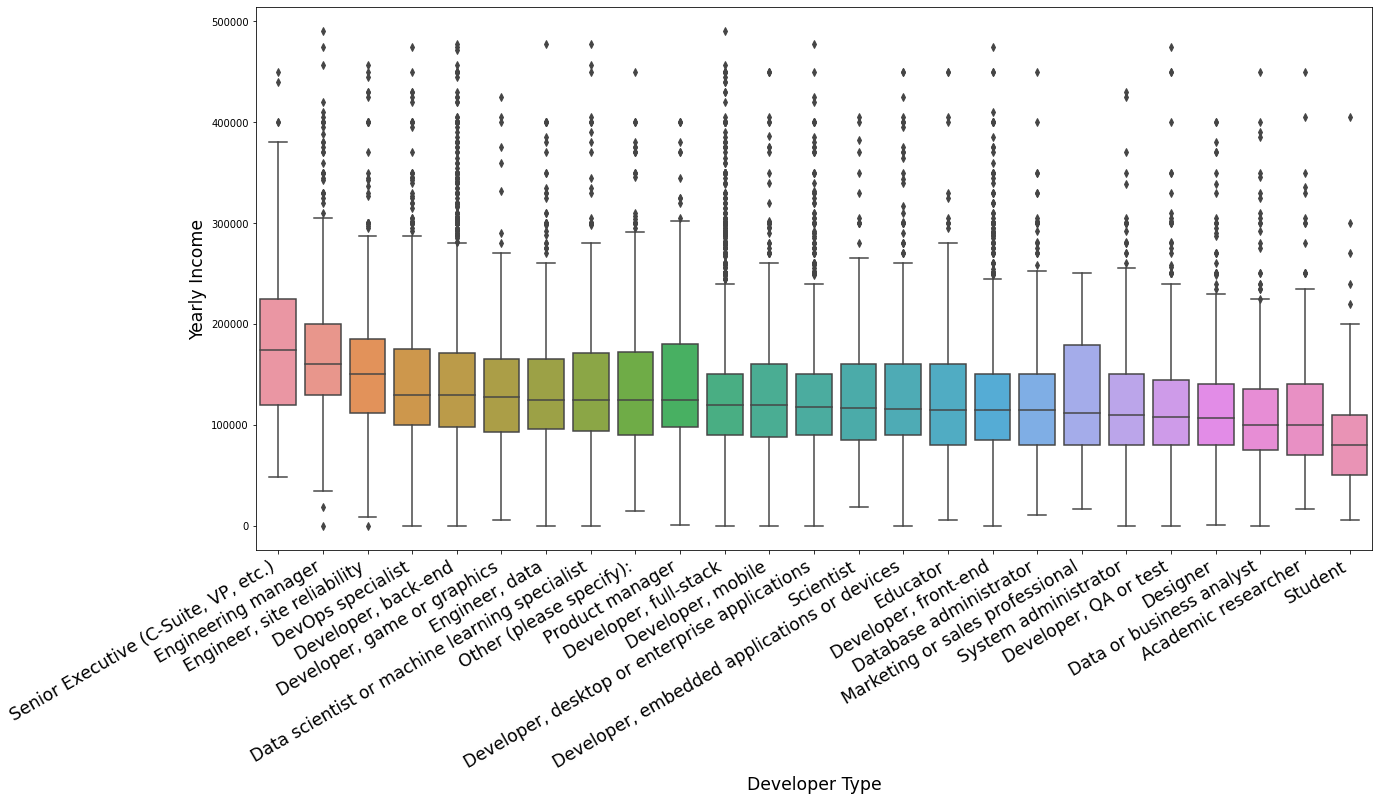

In [191]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=devtype, x="DevType", y="ConvertedCompYearly", order=sorted_dev)
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("Developer Type", fontsize="xx-large")
plt.ylabel("Yearly Income", fontsize="xx-large")
plt.show()

### The box plot shows that:

*   The median salaries between various developer roles are similar except for management roles such as engineering manager, CEO, CTO,... It means that there is no strong correlation between developer type and income.
*   Students seem to earn significantly less salary than other full-time positions.
* The distribution of C-suit executives (CEO, CTO, etc.) is more widely spread than other distributions. It seems to be the salaries of C-suit executives are significantly various based on different company sizes.

Let's verify whether our assumption about C-suit executive's salaries is true or not.




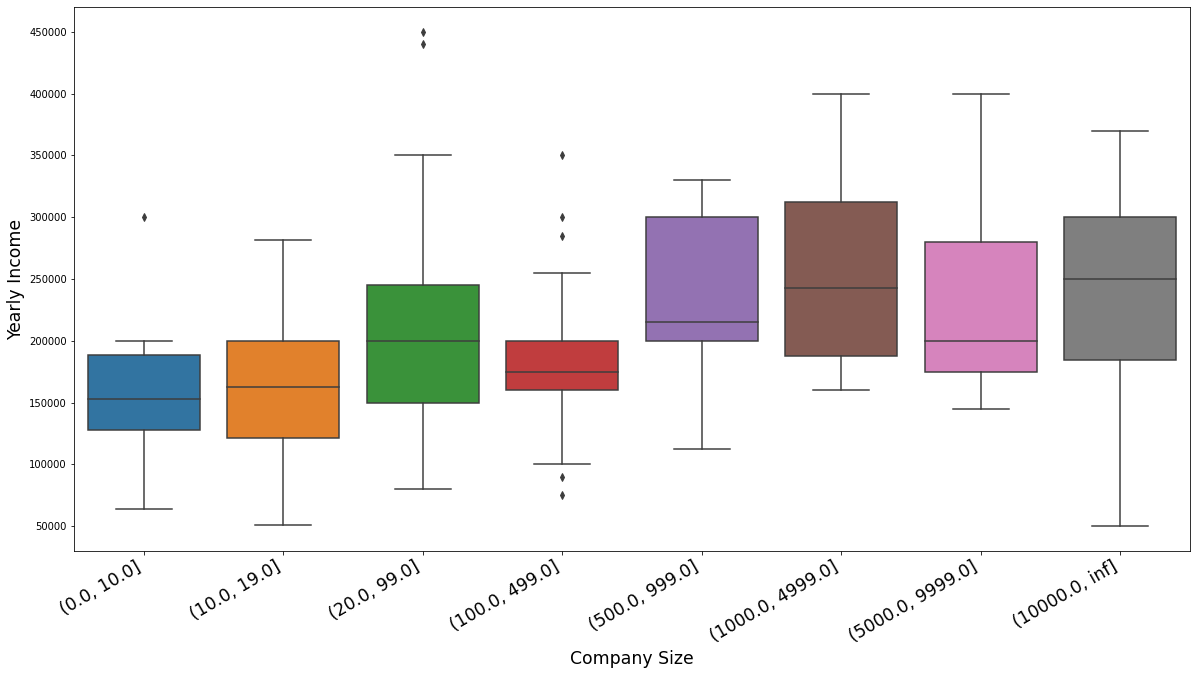

In [192]:
ceo = devtype.query("DevType == 'Senior Executive (C-Suite, VP, etc.)'").sort_values(
    by="OrgSize"
)

sns.boxplot(
    data=ceo,
    x="OrgSize",
    y="ConvertedCompYearly",
)
plt.xticks(rotation=30, ha="right", fontsize="xx-large")
plt.xlabel("Company Size", fontsize="xx-large")
plt.ylabel("Yearly Income", fontsize="xx-large")
plt.show()

Cool! Our assumption is true. The salaries of Senior Executives tend to increase significantly when the company size increase.

## **Conclusion**

*   There is a significant difference in mean salary between developers with fewer years of experience and developers with more years of experience.
*   A formal degree has low to no effect on salary.
*   The median salary increases slightly when the position is higher up and when the company size increases.

#### So should you get a higher degree or get more years of coding experience to earn more income? 
#### From the analysis of based on Stack Overflow Survey data, the better investment is to get more years of experience in your field of interest.








# **Thank you for your attention!**